# Example: Simulating Images with Nonnominal PSFs
---

Throughout JWST OTE commissioning until about MIMF-3 (expected L+118 days), the JWST OTE will not be optimally aligned. The mirrors will be unstacked and unphased, especially for earlier commissioning activities, and thus the nominal JWST PSFs that MIRaGe uses for imaging simulations do not adequately represent the telescope state.

### How to Simulate Images with Nonnominal PSFs
In this notebook, we demonstrate how to simulate images with nonnominal PSFs (as will be the case during OTE commissioning) with MIRaGe. The process is as follows:
- Using `webbpsf`, generate PSF libraries from the desired mirror state for each observation/visit/exposure in a given observation
- Generate MIRaGe YAML input files that include the directory where to find the special PSF libraries
- Generate seed images from those YAMLs that use the appropriate PSF library for any given exposure
- Follow the nominal procedures for adding dark exposure and detector effects

### Table of Contents:
1. [Export program information from APT](#export_apt)
2. [Create diverse PSF library files](#create_psfs)
3. [Create `.yaml` files for each exposure](#make_yamls)
4. [Generate the simulated image](#simulate_images)

Appendix 1: [Generating data for an entire observation](#simulate_whole_obs)

Appendix 2: [Combining data into a mosaic](#mosaic)

<div class="alert alert-block alert-warning">
    
<b>Note:</b> <br>

You must have installed the <code>mirage</code> package before running this notebook. Install it using the following command while in the <code>mirage</code> repository (where the <code>setup.py</code> file is located):<br><br>

<code>pip install -e .</code>

</div>

In [1]:
# Standard Library Imports
import os
import re
import time

# Third Party Imports
import pprint
import shutil
import jwxml
import yaml
import pysiaf
from glob import glob
import numpy as np
# import webbpsf
from astropy.io import fits
from astropy.io import ascii as asc
from astropy.nddata import NDData
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.vizier import Vizier
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import webbpsf

# Local Imports (from nircam_simulator package)
from mirage import imaging_simulator
from mirage.seed_image import catalog_seed_image
from mirage.dark import dark_prep
from mirage.ramp_generator import obs_generator
from mirage.apt import apt_inputs
from mirage.yaml import yaml_generator, generate_observationlist
from mirage.catalogs import get_catalog

# View matplotlib plots inline
%matplotlib inline

---
<a id='export_apt'></a>
# 1. Export APT files

Open the APT file for the program you want to simulate. If you don't have the file locally, you can load this program in APT by selecting `File > Retrieve from STScI > Retrieve Using Proposal ID` and then entering the program ID (e.g. 1140). (You must be running APT in STScI mode for this retrieval method to be available.)

Export the `.pointing` and `.xml` files for your given proposal in APT by selecting `File > Export...` and selecting both the xml and pointing file options. Save them in a place you will remember, naming them something descriptive such as `OTE06_1140.pointing`.

For this example, we will simulate images from OTE-17: Image Stacking 2. In this stage of commissioning, the 18 mirror segments are being moved to transition from a hexagonal image array to 17 stacked segments with one kicked out. We will only look at observation 1, for brevity's sake. The neccessary files, `OTE17-1153-obs1only.pointing` and `OTE17-1153-obs1only.xml`, are located within the `examples/nonnominal_psf_data/` directory.

In [3]:
prop_id = 1153

# Where the pointing and XML file for this particular OTE CAR are located
input_dir = './nonnominal_psf_data/'

# Change the root if you named your files differently.
root = 'OTE17-{}-obs1only'.format(prop_id)
pointing_file = os.path.join(input_dir, '{}.pointing'.format(root))
xml_file = os.path.join(input_dir, '{}.xml'.format(root))

### Define location of output files

The process of generating simulated images with MIRaGe produces a lot of files:
- YAMLs carrying the OTE mirror state
- FITS files of the segment PSF images
- YAMLs carrying the specifications for simulations
- FITS files of the simulated seed, dark, and compiled images

We'll save those also in a local directory here:

In [4]:
# Where to save MIRaGe output
out_dir = './nonnominal_psf_data/output/'

# Where the segment PSF library files will be saved to (and read from!)
library_dir = os.path.join(out_dir, 'gridded_psf_library')

# Make sure both these directories exist
for full_path in [out_dir, library_dir]:
    if not os.path.exists(full_path):
        os.makedirs(full_path)

---
<a id='create_psfs'></a>
# 2. Create unique, nonnominal PSF library files

We outline two methods here of using unique PSFs for each MIRaGe exposure:
- If you have a list of **mirror moves/positions** describing different telescope states throughout the program, use [option 1](#adjustable_ote). We will use `webbpsf` to generate PSFs and then gridded PSF library objects from those telescope states.
- If you have a list of **FITS files** of different telescope states throughout the program, use [option 2](#to_model). We will load the FITS files and convert them to gridded PSF library objects.

We also outline two methods of mapping PSF files to MIRaGe exposures:
- One PSF to **one** exposure - see [option 1](#adjustable_ote)
- One PSF to **multiple** exposures - see [option 2](#to_model)

### Example: Segment Image Array (OTE-06)

As mentioned above, we'll use the infrastructure of observation 1 in OTE-17: Image Stacking 2 (program 1153) for this example. 

This observation is a WFSC Commissioning observations, that includes 17 Wavefront Control (WFC) groups to bring the mirrors in. (17 sets of image-mirror move-image plus 1 additional image.)

So, in order to generate the YAML configuration files for program 1153 observation 1, MIRaGe will need 18  PSF paths. 

We can parse the `.pointing` file to verify that:

In [5]:
# Get the information from the pointing file
apt_prop = apt_inputs.AptInput()
pointing_tab = apt_prop.get_pointing_info(pointing_file, '1153')
n_exposures = len(pointing_tab['visit_id'])
print('MIRaGe requires PSF paths for {} exposures.'.format(len(pointing_tab['visit_id'])))

MIRaGe requires PSF paths for 18 exposures.


<a id='adjustable_ote'></a>
### Option 1: Use `webbpsf.enable_adjustable_ote()` to make a different PSF for each exposure

In this case, we use `webbpsf` to **simulate different PSFs from a defined mirror state**, and we create 18 PSFs - **one for each exposure**.

Ultimately, all that MIRaGe needs to successfully simulate these images with different PSFs is an ordered list of the 18 PSF paths. There are a number of ways you could do that, but here we choose to:
- generate a nested directory structure that matches the program structure
- save each PSF into the corresponding directory (i.e. `Observation001/Visit002/Activity03/PSFLibrary.fits`)
- provide MIRaGe with an ordered list of each PSF path, i.e.:
       [Observation001/Visit001/Activity01/', 'Observation001/Visit001/Activity02/', ...]

#### Generate directory structure

In [6]:
# Create dictionary that mirrors the program structure
program_structure = {}
for i in range(n_exposures):
    obs_num = pointing_tab['obs_num'][i]
    visit_num = pointing_tab['visit_num'][i]
    activity_id = pointing_tab['act_id'][i]
    
    obs_key = 'Observation{}'.format(obs_num)
    visit_key = 'Visit{}'.format(visit_num)
    
    program_structure.setdefault(obs_key, {})
    visit_dict = program_structure[obs_key].setdefault(visit_key, []).append('Activity{}'.format(activity_id))                                                                      
    
pprint.pprint(program_structure)  

{'Observation001': {'Visit001': ['Activity01',
                                 'Activity02',
                                 'Activity03',
                                 'Activity04',
                                 'Activity05',
                                 'Activity06',
                                 'Activity07',
                                 'Activity08',
                                 'Activity09',
                                 'Activity0a',
                                 'Activity0b',
                                 'Activity0c',
                                 'Activity0d',
                                 'Activity0e',
                                 'Activity0f',
                                 'Activity0g',
                                 'Activity0h',
                                 'Activity0i']}}


In [7]:
# Create directory structure based on dictionary

psf_paths = []
program_dir = os.path.join(library_dir, root)
for observation in program_structure.keys():
    for visit in program_structure[observation].keys():
        for activity in program_structure[observation][visit]:
            activity_dir = os.path.join(program_dir, observation, visit, activity)
            if not os.path.exists(activity_dir):
                os.makedirs(activity_dir)
            psf_paths.append(activity_dir)
            
pprint.pprint(glob(program_dir + '/**/', recursive=True))

['./nonnominal_psf_data/output/gridded_psf_library/OTE17-1153-obs1only/',
 './nonnominal_psf_data/output/gridded_psf_library/OTE17-1153-obs1only/Observation001/',
 './nonnominal_psf_data/output/gridded_psf_library/OTE17-1153-obs1only/Observation001/Visit001/',
 './nonnominal_psf_data/output/gridded_psf_library/OTE17-1153-obs1only/Observation001/Visit001/Activity06/',
 './nonnominal_psf_data/output/gridded_psf_library/OTE17-1153-obs1only/Observation001/Visit001/Activity01/',
 './nonnominal_psf_data/output/gridded_psf_library/OTE17-1153-obs1only/Observation001/Visit001/Activity08/',
 './nonnominal_psf_data/output/gridded_psf_library/OTE17-1153-obs1only/Observation001/Visit001/Activity0a/',
 './nonnominal_psf_data/output/gridded_psf_library/OTE17-1153-obs1only/Observation001/Visit001/Activity0f/',
 './nonnominal_psf_data/output/gridded_psf_library/OTE17-1153-obs1only/Observation001/Visit001/Activity0h/',
 './nonnominal_psf_data/output/gridded_psf_library/OTE17-1153-obs1only/Observation001

#### Generate the 18 PSFs

To create different mirror states for this example, we will start with a large image array, not yet coarsely phased, and bring one mirror segment in at a time for each of the 18 exposures.

In [7]:
# Generate starting PSF: a large image array with random pistons.
nc = webbpsf.NIRCam()
nc, ote = webbpsf.enable_adjustable_ote(nc)

# Set up the array
webbpsf.opds.setup_image_array(ote, reset=True, verbose=False, size='large', )

# Add random pistons
random_pistons = np.random.randn(18)*500  # substantial coarse phasing erorrs. 
for i, seg in enumerate(ote.segnames[0:18]):  # don't piston "segment 19" the SM
    ote.move_seg_local(seg, piston=random_pistons[i])

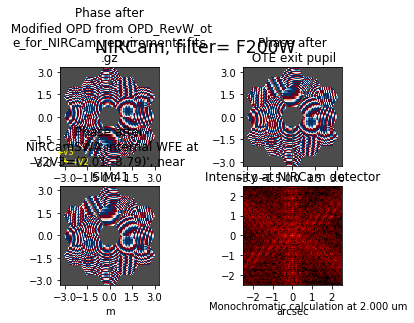

In [8]:
fov_pixels = 2048
original_psf = nc.calc_psf(monochromatic=2e-6, oversample=1, fov_pixels=fov_pixels, display=True)

In [9]:
# Calculate the mirror moves to bring the segments back in
tilt_correction = []
for i, segment in enumerate(ote.segment_state):
    xtilt = segment[0]
    ytilt = segment[1]
    tilt_correction.append((i, -xtilt, -ytilt))
pprint.pprint(tilt_correction)

[(0, 30.607742129488337, -0.0), (1, 30.607742129488337, -0.0), (2, 30.607742129488337, -0.0), (3, 30.607742129488337, -0.0), (4, 30.607742129488337, -0.0), (5, 30.607742129488337, -0.0), (6, -61.21548425897667, -0.0), (7, -0.0, 53.014164473240214), (8, -61.21548425897667, -0.0), (9, -0.0, 53.014164473240214), (10, -61.21548425897667, -0.0), (11, -0.0, 53.014164473240214), (12, -61.21548425897667, -0.0), (13, -0.0, 53.014164473240214), (14, -61.21548425897667, -0.0), (15, -0.0, 53.014164473240214), (16, -61.21548425897667, -0.0), (17, -0.0, 53.014164473240214), (18, -0.0, -0.0)]


In [ ]:
def create_psf_lib_for_ote(i):
    obs = 'Observation{}'.format(pointing_tab['obs_num'][i])
    visit = 'Visit{}'.format(pointing_tab['visit_num'][i])
    visit_dir = os.path.join(program_dir, obs, visit)
    
    print('Calculating PSF for obs {}, visit {}, exposure {}'
          .format(pointing_tab['obs_num'][i], pointing_tab['visit_num'][i], i + 1))

    i_seg, x_tilt_corr, y_tilt_corr = tilt_correction[i]
    ote.move_seg_local(ote.segnames[i_seg], xtilt=x_tilt_corr, ytilt=y_tilt_corr)
    nc.pupil = ote
    
    # Define the filter
    nc.filter = 'F212N'
    nc.detector = 'NRCA3'
    
    # Write out file
    filename = 'nircam_fovp{}_samp1_npsf1.fits'.format(fov_pixels)
    outfile = os.path.join(visit_dir, filename)
    print(outfile)

#     # Generate the PSF grid
#     grid = nc.psf_grid(num_psfs=1, save=True, all_detectors=False,
#                            use_detsampled_psf=True, fov_pixels=fov_pixels,
#                             oversample=1, outfile=outfile)
    
    print('Elapsed time: {}\n'.format(time.time() - start_time))

In [58]:
def create_psf_lib_for_ote(i):
    start_time = time.time()
    obs = 'Observation{}'.format(pointing_tab['obs_num'][i])
    visit = 'Visit{}'.format(pointing_tab['visit_num'][i])
    visit_dir = os.path.join(program_dir, obs, visit)
    
    print('Calculating PSF for obs {}, visit {}, exposure {}'
          .format(pointing_tab['obs_num'][i], pointing_tab['visit_num'][i], i + 1))

    i_seg, x_tilt_corr, y_tilt_corr = tilt_correction[i]
    ote.move_seg_local(ote.segnames[i_seg], xtilt=x_tilt_corr, ytilt=y_tilt_corr)
    nc.pupil = ote
    
    # Define the filter
    nc.filter = 'F212N'
    nc.detector = 'NRCA3'
    
    # Write out file
    filename = 'nircam_fovp{}_samp1_npsf1.fits'.format(fov_pixels)
    outfile = os.path.abspath(os.path.join(visit_dir, filename))
    print(outfile)

    # Generate the PSF grid
    grid = nc.psf_grid(num_psfs=1, save=True, all_detectors=False,
                           use_detsampled_psf=True, fov_pixels=fov_pixels,
                            oversample=1, outfile=outfile)
    
    print('Elapsed time: {}\n'.format(time.time() - start_time))

<div class="alert alert-block alert-warning">
    
<b>Warning:</b> <br>

The for loop below will take a while: about 1.5 minutes per detector per filter! We've written it so that it will only write out for NIRCam A3 with the F212N filter, but even that will take almost half an hour to complete. If you want to generate more PSFs than that, it might be a good idea to run it overnight!

</div>

In [59]:
for i in range(n_exposures):
    create_psf_lib_for_ote(i)

Calculating PSF for obs 001, visit 001, exposure 1
/Users/lchambers/TEL/mirage/mirage_repo/examples/nonnominal_psf_data/output/gridded_psf_library/OTE17-1153-obs1only/Observation001/Visit001/nircam_fovp2048_samp1_npsf1.fits

Running instrument: NIRCam, filter: F212N
  Running detector: NRCA3
    Position 1/1: (1023, 1023) pixels
  Saving file: /Users/lchambers/TEL/mirage/mirage_repo/examples/nonnominal_psf_data/output/gridded_psf_library/OTE17-1153-obs1only/Observation001/Visit001/nircam_fovp2048_samp1_npsf1_nrca3_f212n.fits
Elapsed time: 78.98274087905884

Calculating PSF for obs 001, visit 001, exposure 2
/Users/lchambers/TEL/mirage/mirage_repo/examples/nonnominal_psf_data/output/gridded_psf_library/OTE17-1153-obs1only/Observation001/Visit001/nircam_fovp2048_samp1_npsf1.fits

Running instrument: NIRCam, filter: F212N
  Running detector: NRCA3
    Position 1/1: (1023, 1023) pixels


KeyboardInterrupt: 

<a id='to_model'></a>
### Option 2: Use `webbpsf.gridded_library.CreatePSFLibrary.to_model()` to use a different PSF FITS file for each visit

In [8]:
# Note: you must have access to the STScI central storage directories to use this data.
psf_fits_data_dir = '/grp/jwst/ote/mirage_example_data/'
all_ote17_fits = sorted(glob(psf_fits_data_dir + '*.fits'))
all_ote17_fits

['/grp/jwst/ote/mirage_example_data/jw00173_010_001_01100_00000_NRCA3_img.fits',
 '/grp/jwst/ote/mirage_example_data/jw00173_010_001_01100_00001_NRCA3_img.fits',
 '/grp/jwst/ote/mirage_example_data/jw00173_010_001_01100_00002_NRCA3_img.fits',
 '/grp/jwst/ote/mirage_example_data/jw00173_010_001_01100_00003_NRCA3_img.fits',
 '/grp/jwst/ote/mirage_example_data/jw00173_010_001_01100_00004_NRCA3_img.fits',
 '/grp/jwst/ote/mirage_example_data/jw00173_010_001_01100_00005_NRCA3_img.fits',
 '/grp/jwst/ote/mirage_example_data/jw00173_010_001_01100_00006_NRCA3_img.fits',
 '/grp/jwst/ote/mirage_example_data/jw00173_010_001_01100_00007_NRCA3_img.fits',
 '/grp/jwst/ote/mirage_example_data/jw00173_010_001_01100_00008_NRCA3_img.fits',
 '/grp/jwst/ote/mirage_example_data/jw00173_010_001_01100_00009_NRCA3_img.fits',
 '/grp/jwst/ote/mirage_example_data/jw00173_010_001_01100_00010_NRCA3_img.fits',
 '/grp/jwst/ote/mirage_example_data/jw00173_010_001_01100_00011_NRCA3_img.fits',
 '/grp/jwst/ote/mirage_examp

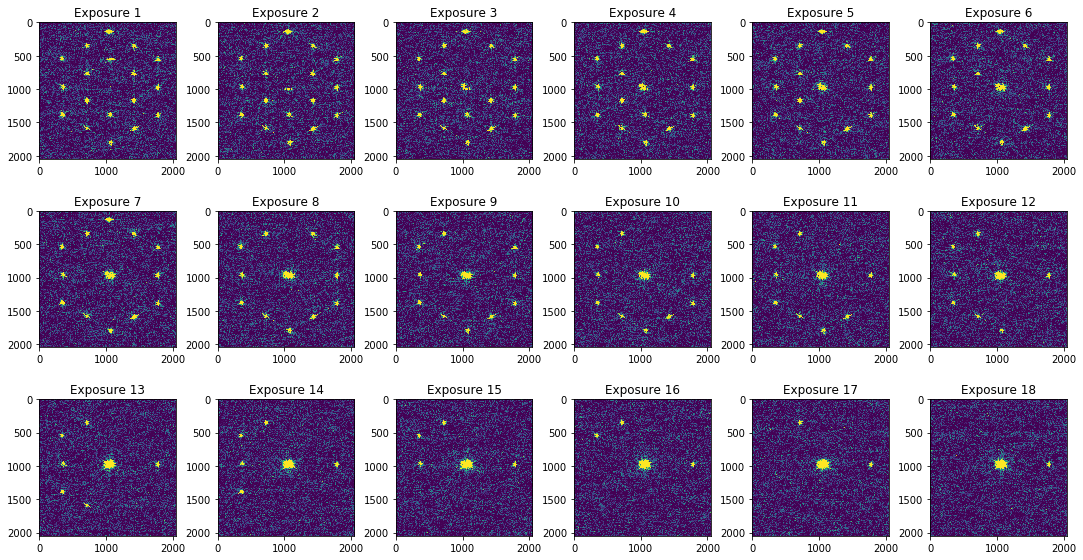

In [29]:
# Just for fun, plot all the data
fig, axes = plt.subplots(3, 6, figsize=(15, 8))
plt.tight_layout()

i = 1
for ax, f in zip(axes.flatten(), all_ote17_fits):
    with fits.open(f) as hdulist:
        psf_data = hdulist[1].data
    ax.imshow(psf_data, clim=(0.1, 100))
    ax.set_title('Exposure {}'.format(i))
    i += 1
        
plt.show()

In [34]:
# Copy the images into the observation/visit/activity-specific directories
for psf_path, fits_file in zip(psf_paths, all_ote17_fits):
    shutil.copy(fits_file, psf_path)
    print('Copied PSF to: {}'.format(os.path.abspath(os.path.join(psf_path, os.path.basename(fits_file)))))
    print()

Copied PSF to: /Users/lchambers/TEL/mirage/mirage_repo/examples/nonnominal_psf_data/output/gridded_psf_library/OTE17-1153-obs1only/Observation001/Visit001/Activity01/jw00173_010_001_01100_00000_NRCA3_img.fits

Copied PSF to: /Users/lchambers/TEL/mirage/mirage_repo/examples/nonnominal_psf_data/output/gridded_psf_library/OTE17-1153-obs1only/Observation001/Visit001/Activity02/jw00173_010_001_01100_00001_NRCA3_img.fits

Copied PSF to: /Users/lchambers/TEL/mirage/mirage_repo/examples/nonnominal_psf_data/output/gridded_psf_library/OTE17-1153-obs1only/Observation001/Visit001/Activity03/jw00173_010_001_01100_00002_NRCA3_img.fits

Copied PSF to: /Users/lchambers/TEL/mirage/mirage_repo/examples/nonnominal_psf_data/output/gridded_psf_library/OTE17-1153-obs1only/Observation001/Visit001/Activity04/jw00173_010_001_01100_00003_NRCA3_img.fits

Copied PSF to: /Users/lchambers/TEL/mirage/mirage_repo/examples/nonnominal_psf_data/output/gridded_psf_library/OTE17-1153-obs1only/Observation001/Visit001/Activ

In [64]:
f = '/Users/lchambers/TEL/mirage/mirage_repo/examples/nonnominal_psf_data/output/gridded_psf_library/OTE17-1153-obs1only/Observation001/Visit001/Activity01/jw00173_010_001_01100_00000_NRCA3_img.fits'
with fits.open(f) as hdulist:
    hdulist.info()
#     hdulist.getdata(f)


Filename: /Users/lchambers/TEL/mirage/mirage_repo/examples/nonnominal_psf_data/output/gridded_psf_library/OTE17-1153-obs1only/Observation001/Visit001/Activity01/jw00173_010_001_01100_00000_NRCA3_img.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   ()      
  1  SCI           1 ImageHDU        22   (2048, 2048)   float32   
  2  DQ            1 ImageHDU        12   (2048, 2048)   int16   


In [63]:
fits.getdata(f)

array([[  3., -32.,  20., ...,   5.,   8., -23.],
       [-20.,  12.,  10., ...,   4.,   1., -39.],
       [-12.,   2., -25., ...,  12., -13.,  48.],
       ...,
       [-13.,  -5.,  -2., ...,  15.,  11., -12.],
       [ -3.,  15.,   8., ...,   5.,  29.,  25.],
       [ -2.,  17.,  26., ...,   2.,   9., -11.]], dtype=float32)

In [66]:
fits.getheader(f)

SIMPLE  =                    T / Written by IDL:  Tue Jan 23 13:33:30 2018      
BITPIX  =                    8 / Number of bits per data pixel                  
NAXIS   =                    0 / Number of data axes                            
EXTEND  =                    T / FITS data may contain extensions               
DATE    = '2018-01-23'         / Creation UTC (CCCC-MM-DD) date of FITS header  
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    
TELESCOP= 'JWST    '           /                                                
ORIGIN  = 'ITM     '           /                                                
SCA_ID  = '483     '           /                                                
DETECTOR= 'NRCA3   '           /                                                
TARGNAME= 'BOZOS STAR'         /                                                
RA_TARG =              33.00

---
<a id='make_yamls'></a>
# 3. Create YAML files for each exposure

Next, we need to make the YAML files that include all of the parameters for MIRaGe to run.

### Query online catalogs to generate catalog files of sources in FOV

Next, we need to generate catalog files for the sources around the target in this proposal. First we must parse the `.pointing` file to determine the RA and Dec of the target (or targets) that will be observed. Then we will query 2MASS and WISE to get the magnitudes and locations of shortwave and longwave sources, respectively, around the target.

All of this can be accomplished with the `mirage.get_catalog.get_all_catalogs` function.

These catalog files will be written to your local `mirage/catalogs/` directory. If files for a given catalog and RA/Dec have already been generated, they will not be regenerated.

<div class="alert alert-block alert-warning">
    
<b>Important:</b> <br>

Querying 2MASS and WISE is only appropriate for observations with the F212N and F480M NIRCam filters. If you want to simulate observations that use other filters, you will have to either query different bandpasses or catalogs or perform a photometric conversion on an existing catalog.

</div>

In [35]:
# Get SW and LW catalogs
cats = get_catalog.get_all_catalogs(pointing_file, prop_id)
target_coords, catalog_filenames_sw, catalog_filenames_lw = cats

cat_dict = {'nircam': {'lw': catalog_filenames_lw,
                       'sw': catalog_filenames_sw}}

Target coordinates:  273.08917 65.60481
Shortwave catalog file 2MASS_RA273.09deg_Dec65.60deg.list already exists. Will not overwrite.
Longwave catalog file WISE_RA273.09deg_Dec65.60deg.list already exists. Will not overwrite.


### Generate the `.yaml` files

Use `mirage.yaml.yaml_generator` to make all of the YAML files for the given APT program - one file per exposure.

**Some additional settings are required to ensure `yaml_generator` works for nonnominal PSF simulations.** You must specify the `psf_paths` attribute before running `create_inputs()` to make the YAMLs, and thus simulations, correctly. That attribute can be a couple of different kinds of types:
- **A string pointing to a directory** - the matching PSF library in that directory will be written into ALL YAMLs, and thus will be used for ALL exposures in the program
- **A list of strings pointing to a list of directories** - Each listed directory will be written into the corresponding YAML (in alphanumeric order), and thus each exposure will be simulated using their respective, potentally different, PSF library. The list must be the same length as the number of exposures in the program.

In [68]:
# Create a series of data simulator input yaml files from APT files
# (Within this, create the observation table.)
yaml_dir = os.path.join(out_dir, 'yamls')
yam = yaml_generator.SimInput(input_xml=xml_file, pointing_file=pointing_file,
                              catalogs=cat_dict,
                              verbose=True, output_dir=yaml_dir, simdata_output_dir=out_dir)
yam.psf_paths = psf_paths
yam.add_psf_wings = False
yam.create_inputs()

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Observation `001` labelled `Move In 17 Segments` uses template `WfscCommissioning`
APTObservationParams Dictionary holds 0 entries before reading template
Dictionary read from template has 18 entries.
Found 0.0 tile(s) for observation 001 Move In 17 Segments
Found 1 visits with numbers: [1]
APTObservationParams Dictionary holds 18 entries after reading template (+18 entries)
Finished reading APT xml file.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Number of entries before expanding dithers: 18
Number of entries after expanding dithers:  18
Expanded table for Observation 001 has 18 entries

Wrote 1 observations and 18 entries to /Users/lchambers/TEL/mirage/mirage_repo/examples/nonnominal_psf_data/output/yamls/observation_list.yaml
NOTE: Using pre-delivery SIAF data for NIRCAM
csv exposure list written to /Users/lchambers/TEL/mirag

## Let's examine where the sources will fall in an example exposure

### Examine target pointings relative to apertures and V2/V3 references

Looking at the `.pointing` file, let's plot where the target will appear relative to the NIRCam apertures for each unique pointing.

Example files for each pointing:
--------------------------------
1. jw01153001001_01101_00001_nrca4.yaml


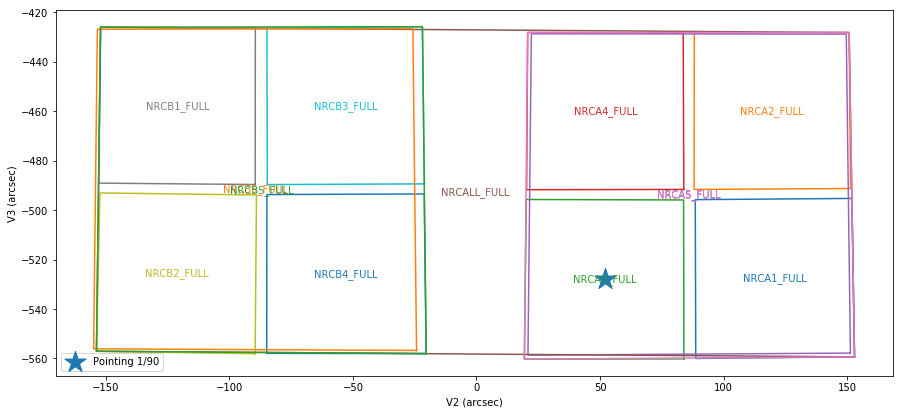

In [40]:
# Examine apertures and V2/V3 references for each array/subarray
nc_siaf = pysiaf.Siaf('NIRCam')
nc_full = nc_siaf['NRCA1_FULL']

plt.figure(figsize=(15,10))
for apername in sorted(nc_siaf.apernames):
    a = apername
    if ('_FULL' in a) and ('OSS' not in a) and ('MASK' not in a) and (a[-1] != 'P'):
        nc_siaf[a].plot(frame='tel', name_label=a, fill_color='white')
plt.gca().invert_xaxis()

# Compare V2/V3 of targets (from .pointing file)
all_pointings = set([(v2, v3, filename) for v2, v3, filename in zip(yam.info['v2'], 
                                                                yam.info['v3'], 
                                                                yam.info['yamlfile'])])

print('Example files for each pointing:')
print('--------------------------------')
plotted_points = []
for i_point, (v2, v3, filename) in enumerate(all_pointings):
    if (v2, v3) not in plotted_points:
        plotted_points.append((v2, v3))
        plt.scatter(v2, v3, marker='*', s=500, 
                    label='Pointing {}/{}'.format(i_point + 1, len(all_pointings)))
        print('{}. {}'.format(i_point + 1, filename))

plt.legend()

plt.show()

MIRaGE can only generate one simulated exposure at a time, so even though we have 135 yaml files in our `ote_dir` directory, we need to choose just one to produce an image. Since each exposure points in a different place, we should choose an exposure that places the target star in the desired detector FOV.

It looks like pointing number 1 in the A3 detector would be a good choice (the blue star in the green left box). So, looking at the printed output, we want to use the yaml called `jw01140005001_0112n_00001_nrca3.yaml`.

> Note: as described on [JDox](https://jwst-docs.stsci.edu/display/JDAT/File+Naming+Conventions+and+Data+Products), the yaml files are named like so:<br><br>
> `jw<PPPPP><OOO><VVV>_<GGSAA>_<EEEEE>_<detector>.yaml`<br><br>
> where:
> * P = proposal number
> * O = observation number
> * V = visit number
> * G = Visit Group
> * S = Parallel Sequence id (1 prime, 2-5 parallel)
> * A = Activity number (base 36)
> * E = exposure number
> 
> So `jw01140005001_0112n_00001_nrca3.yaml` would be the first visit in the fifth observation of APT proposal 1140, exposure 1, taken with the A3 detector.

In [51]:
yfiles = glob(os.path.join(yaml_dir, '*.yaml'))
file_name_to_match = 'jw01153001001_01101_00001_nrca3'
yaml_to_sim = os.path.abspath([y for y in yfiles if file_name_to_match in y][0])
print(yaml_to_sim)

/Users/lchambers/TEL/mirage/mirage_repo/examples/nonnominal_psf_data/output/yamls/jw01153001001_01101_00001_nrca3.yaml


---
<a id='simulate_images'></a>
# 4. Simulate image with MIRaGe

Finally, we can run MIRaGe to generate a seed image simulation of our unstacked mirror state during OTE-01.

From here on out, from the user perspective, the simulation process is identical for nominal imaging cases (see the [imaging example notebook](#Imaging_simulator_use_examples.ipynb). The specifications made in the YAML files are what enable the specialized behavior needed to simulate unstacked mirror simulations with MIRaGe.

In [54]:
print(yaml_to_sim)

/Users/lchambers/TEL/mirage/mirage_repo/examples/nonnominal_psf_data/output/yamls/jw01153001001_01101_00001_nrca3.yaml


In [69]:
img_sim = imaging_simulator.ImgSim()
img_sim.paramfile = yaml_to_sim
img_sim.create()

Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
NOTE: Using pre-delivery SIAF data for NIRCam
SIAF: Requested NRCA3_FULL   got NRCA3_FULL
Calculating background rate using jwst_background based on low level
Using /Users/lchambers/TEL/mirage/mirage_repo/mirage/config/F212N_nircam_plus_ote_throughput_moda_sorted.txt filter throughput file for background calculation.
Background level set to: 4.1788997249321594e-05
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
output dimensions are: [2048 2048]
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Frametime is 10.736770000000002
Is this an ITM simulation? True
PSFs will be generated using: jw00173_010_001_01100_00000_NRCA3_img.fits
Creating signal rate image of synthetic inputs.
Calculating point source lists
Point list input positions assumed to be in units of RA and Dec.
Filtering point sources to keep only those on the detector
Number of point sources found within the requested aperture: 10


WCS info for /Users/lchambers/TEL/mirage/mirage_repo/examples/nonnominal_psf_data/output/jw01153001001_01101_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/Users/lchambers/TEL/mirage/mirage_repo/examples/nonnominal_psf_data/output/jw01153001001_01101_00001_nrca3_linear.fits
Observation generation complete.


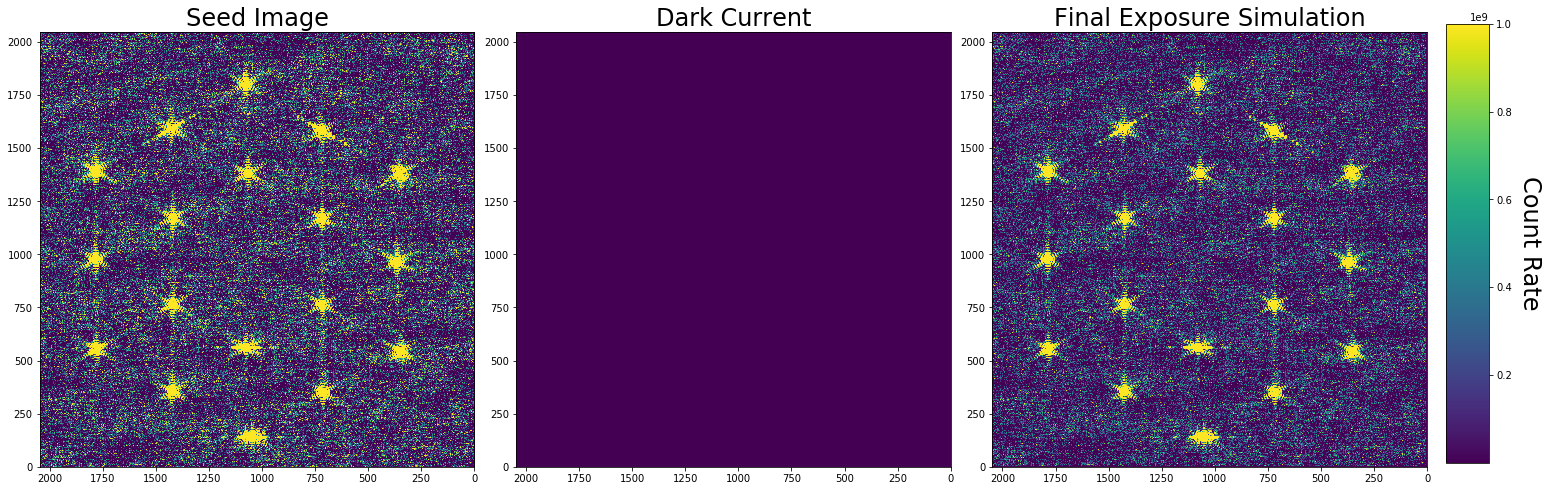

In [78]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(20, 7))
plt.tight_layout()

clim = (10, 1e9)

fitsplot = ax1.imshow(img_sim.seedimage, clim=clim)
ax1.set_title('Seed Image', size=24)
ax1.invert_xaxis()
ax1.invert_yaxis()

ax2.imshow(img_sim.linDark.data[0,-1,:,:] - img_sim.linDark.data[0,0,:,:], clim=clim)
ax2.set_title('Dark Current', size=24)
ax2.invert_xaxis()
ax2.invert_yaxis()

linear_output = './nonnominal_psf_data/output/jw01153001001_01101_00001_nrca3_linear.fits'
with fits.open(linear_output) as h:
    lindata = h[1].data
    header = h[0].header
exptime = header['EFFINTTM']
diffdata = (lindata[0,-1,:,:] - lindata[0,0,:,:]) / exptime

ax3.imshow(diffdata, clim=clim)
ax3.set_title('Final Exposure Simulation', size=24)
ax3.invert_xaxis()
ax3.invert_yaxis()

# Define the colorbar
cbar_ax = fig.add_axes([1, 0.09, 0.03, 0.87])
cbar = plt.colorbar(fitsplot, cbar_ax)
cbar.set_label('Count Rate', rotation=270, labelpad=30, size=24)

---
<a id='simulate_whole_obs'></a>
# Appendix 1: Simulating many exposures at once

Chances are, you don't want to simulate just one exposure from one detector. In order to simulate all of the exposures from a given observation, write a for loop to iterate over all the YAMLs. We include an example for program 1134 observation 1 below.

### 1. Create all PSF library files
First, make sure that you have created library files for all of the filters and detectors that will be simulated in your observation (for program 1134 observation 1 this means all detectors and filters F212N and F480M):
```python
from mirage.psfs import segment_psfs

segment_psfs.generate_segment_psfs(ote, segment_tilts, library_dir, 
                                   filters=['F212N', 'F480M'], detectors='all')
```

### 2. Run `imaging_simulator` for all YAMLs
Second, grab all of the YAMLs for that specific observation and run the whole image simulator on them all.
```python
from mirage import imaging_simulator

# Get all the 1134 Obs 1 NRCA3 yamls
all_yaml_files = glob(ote_dir + 'jw01134001*.yaml')
n_yamls = len(all_yaml_files)
print('{} FITS files will be generated.'.format(n_yamls))

for yaml in all_yaml_files:
    print('*** SIMULATING YAML {}/{}: {} ***'.format(i+1, n_yamls, yaml))
    img_sim = imaging_simulator.ImgSim()
    img_sim.paramfile = yaml
    img_sim.create()
```

(If you are impatient and ambitious, you can use Python's `multiprocessing` module to the simulation go faster. Even better on a server with more processors! See the [Non-nominal PSF example notebook](#Nonnominal_PSF_simulations_use_examples.ipynb) for a working example of that.)

---
<a id='mosaic'></a>
# Appendix 2: Combine into a mosaic

### Turn linear FITS products into slope images
```python
obs1_fits = glob(os.path.join(ote_dir, 'jw*linear.fits'))
print('{} FITS files produced for program APT 1134 Observation 1'.format(len(obs1_fits)))

# Subtract the first from last for each ramp
for f in obs1_fits:
    with fits.open(f) as hdulist:
        data = hdulist[1].data
        hdr = hdulist[1].header
        
    diff = data[0, -1] - data[0, 0]

    hdu = fits.PrimaryHDU(data=diff, header=hdr)

    new_filename = os.path.join(ote_dir, 'slope_fits', os.path.basename(f))
    hdu.writeto(new_filename, overwrite=True)
    
obs1_slope_fits = glob(os.path.join(ote_dir, 'slope_fits', 'jw*linear.fits'))
```


### Make ops file for QUIP
```python
# Set variables for writing QUIP ops file
outdir = os.path.join(out_dir, 'quip')
outfile = 'congrid'
bindim = 2048
opsfile = outdir+'ops_file_'+outfile.strip("/")+str(bindim)+'.xml'

# Write the file
f = open(opsfile,'w')

f.write('<?xml version="1.0" encoding="UTF-8" standalone="yes"?>\n')
f.write('<QUIP_OPERATION_FILE xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" creator="WSS Executive" time="16:22:40.093Z" date="2017-06-14Z" version="6.0.1" operational="false" xsi:noNamespaceSchemaLocation="/Users/lajoie/TEL/WSS-6.0.1/Software/schema/quip_operation_file.xsd">\n')
f.write('    <CORRECTION_ID>R2017061401</CORRECTION_ID>\n')
f.write('    <OPERATION_TYPE>THUMBNAIL</OPERATION_TYPE>\n')
f.write('    <IMAGES>\n')

for filename in obs1_slope_fits:
    f.write("       <IMAGE_PATH>{:s}</IMAGE_PATH>\n".format(filename))
    
f.write( '       </IMAGES>\n'    )
f.write( '       <OUTPUT>\n')
f.write( '           <OUTPUT_DIRECTORY>{:s}quip/</OUTPUT_DIRECTORY>\n'.format(outdir))
f.write( '           <LOG_FILE_PATH>{:s}quip/R2017061401_quip_activity_log.xml</LOG_FILE_PATH>\n'.format(outdir))
f.write( '           <OUT_FILE_PATH>{:s}quip/R2017061401_quip_out.xml</OUT_FILE_PATH>\n'.format(outdir))
f.write( '       </OUTPUT>\n')

f.write('</QUIP_OPERATION_FILE>\n')

f.close()

print('Successfully wrote QUIP ops file to', opsfile)
```